# Задание: Метрики и функции потерь в регрессии (Wine Quality)


## 1. Загрузка библиотек и данных

Используем датасет `mnemoraorg/wine-quality-6k4` из Hugging Face Datasets. Целевая переменная — `quality`.


In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
sns.set(style="whitegrid", context="notebook")

/Users/vdgerman/cloud/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("mnemoraorg/wine-quality-6k4")
df = dataset["train"].to_pandas()
df.head()

Generating train split: 100%|██████████| 6497/6497 [00:00<00:00, 194120.15 examples/s]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [4]:
df.describe(include="all")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## 2. Подготовка данных и разбиение на выборки

Разделим данные на обучающую, валидационную и тестовую части в соотношении 60/20/20 с фиксированным `random_state`. Предобработку (масштабирование числовых и кодирование категориальных признаков) реализуем внутри `Pipeline`, чтобы избежать утечек данных.


In [ ]:
target_col = "quality"
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

len(X_train), len(X_val), len(X_test)

(3897, 1300, 1300)

## 3. Бейзлайны: константные предсказатели

Построим два простых бейзлайна на основе `y_train`: предсказание средним и медианой. Для них рассчитаем MAE, RMSE и R² на валидационной выборке.


In [7]:
def regression_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}

baseline_results = []

mean_value = y_train.mean()
y_val_pred_mean = np.full(shape=y_val.shape, fill_value=mean_value, dtype=float)
baseline_results.append(regression_metrics(y_val, y_val_pred_mean, "Baseline: mean(y_train)"))

median_value = y_train.median()
y_val_pred_median = np.full(shape=y_val.shape, fill_value=median_value, dtype=float)
baseline_results.append(regression_metrics(y_val, y_val_pred_median, "Baseline: median(y_train)"))

baseline_df = pd.DataFrame(baseline_results)
baseline_df

,model,MAE,RMSE,R2
0,Baseline: mean(y_train),0.704285,0.906233,-0.000256
1,Baseline: median(y_train),0.653077,0.922788,-0.037136


### MAE
MAE = 0.70 для среднего и = 0.65 для медианы означает, что типичное модульное расхождение между константным прогнозом и реальным значением quality составляет около 0.65-0.70 единицы шкалы целевой переменной.
​

То, что медиана даёт меньший MAE, ожидаемо: константное предсказание медианой - это именно значение, которое минимизирует среднюю абсолютную ошибку.

### RMSE
RMSE = 0.91-0.92 чуть больше, чем MAE, значит в выборке есть относительно немного более крупных ошибок, которые сильнее влияют на квадратичную метрику, но они не доминируют (иначе разрыв между RMSE и MAE был бы заметно больше).

Среднее даёт чуть меньший RMSE, чем медиана (0.906 против 0.923), что тоже логично: именно среднее значение минимизирует среднеквадратичную ошибку.

### R²
Значения R² около 0 и немного отрицательные показывают, что обе константные модели практически не объясняют изменчивость quality и служат только опорной точкой для сравнения.

Небольшая разница между R² для среднего и медианы говорит о том, что по "объяснённой дисперсии" эти бейзлайны почти равносильны, и любая разумная модель должна давать R² заметно выше нуля.

## 4. Линейная модель (LinearRegression)

Обучим линейную регрессию в конвейере с предобработкой и сравним её качество с бейзлайнами по MAE, RMSE и R². Затем построим графики предсказаний и остатков.


In [8]:
linreg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())]
)

linreg_pipeline.fit(X_train, y_train)

y_train_pred_lin = linreg_pipeline.predict(X_train)
y_val_pred_lin = linreg_pipeline.predict(X_val)

linreg_results = []
linreg_results.append(regression_metrics(y_train, y_train_pred_lin, "LinearRegression train"))
linreg_results.append(regression_metrics(y_val, y_val_pred_lin, "LinearRegression val"))

linreg_df = pd.DataFrame(linreg_results)
linreg_df

,model,MAE,RMSE,R2
0,LinearRegression train,0.565856,0.728084,0.293884
1,LinearRegression val,0.577788,0.752154,0.310959


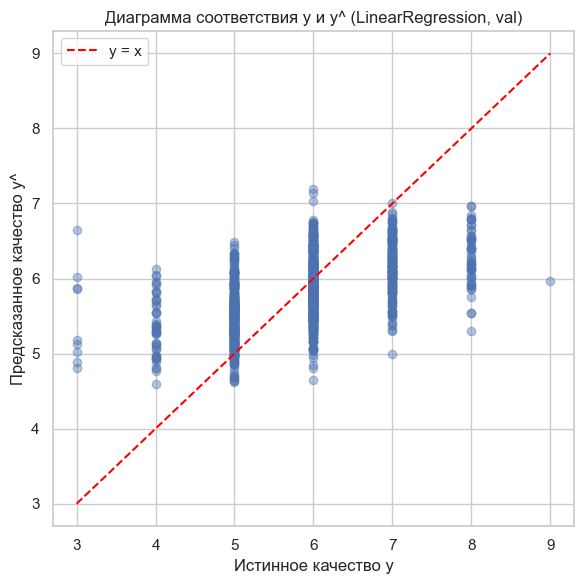

In [22]:
# Диаграмма соответствия y и y^ на валидационной выборке
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred_lin, alpha=0.4)
max_val = max(y_val.max(), y_val_pred_lin.max())
min_val = min(y_val.min(), y_val_pred_lin.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="y = x")
plt.xlabel("Истинное качество y")
plt.ylabel("Предсказанное качество y^")
plt.title("Диаграмма соответствия y и y^ (LinearRegression, val)")
plt.legend()
plt.tight_layout()
plt.show()

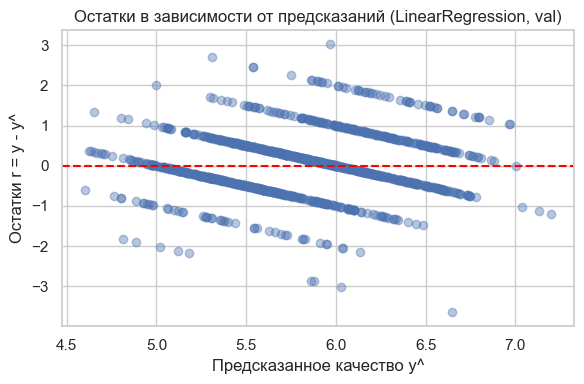

In [10]:
# График остатков r = y - y^ в зависимости от y^
residuals = y_val - y_val_pred_lin
plt.figure(figsize=(6, 4))
plt.scatter(y_val_pred_lin, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Предсказанное качество y^")
plt.ylabel("Остатки r = y - y^")
plt.title("Остатки в зависимости от предсказаний (LinearRegression, val)")
plt.tight_layout()
plt.show()

### Линейность
На графике остатки не образуют горизонтальное "облако" вокруг нуля: заметен наклонённый вниз «коридор» - при меньших предсказанных значениях остатки в среднем положительные, при больших - отрицательные.
​

Это значит, что линейная модель систематически недооценивает одни объекты и переоценивает другие; есть нелинейная структура, которую простая линейная регрессия не ловит (нужно добавить нелинейности/взаимодействия или другую модель).

Отдельные параллельные "полосы" на графике связаны с тем, что целевая переменная дискретная (целое качество), а предсказания непрерывные, поэтому разности y - y^ принимают ограниченный набор значений.

### Выбросы
Часть точек имеет остатки по модулю больше 2–3, заметно отстоящие от основной массы.
​
Такие наблюдения можно считать выбросами по ошибке модели: на этих винах линейная регрессия даёт сильно неточные прогнозы.

### Гетероскедастичность
В идеале разброс остатков вокруг нуля не должен зависеть от уровня предсказаний.
На графике разброс остатка по вертикали примерно сопоставим во всём диапазоне y^, но местами видна чуть большая вертикальная «толщина» облака — особенно в средней части; это говорит скорее о слабой или умеренной гетероскедастичности, а не о ярко выраженном «веере».

## 5. Сравнение функций потерь: MSE vs MAE

Для наглядного сравнения влияния функции потерь обучим два случайных леса с одинаковыми гиперпараметрами, но разными критериями разбиения: `squared_error` (MSE) и `absolute_error` (MAE). Оценим MAE, RMSE и R² на валидационной выборке.


In [ ]:
from sklearn.linear_model import LinearRegression, QuantileRegressor

lin_mse = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]
)

lin_mae = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", QuantileRegressor(
            quantile=0.5,
            alpha=0.0,
            solver="highs",
        )),
    ]
)


loss_results = []

lin_mse.fit(X_train, y_train)
y_val_pred_lin_mse = lin_mse.predict(X_val)
loss_results.append(
    regression_metrics(y_val, y_val_pred_lin_mse, "Linear (MSE) val")
)

lin_mae.fit(X_train, y_train)
y_val_pred_lin_mae = lin_mae.predict(X_val)
loss_results.append(
    regression_metrics(y_val, y_val_pred_lin_mae, "Linear (MAE) val")
)

loss_df = pd.DataFrame(loss_results)
loss_df

,model,MAE,RMSE,R2
0,Linear (MSE) val,0.577788,0.752154,0.310959
1,Linear (MAE) val,0.576300,0.753197,0.309047


### Интерпретация
MAE. Модель с MAE-ориентированной функцией потерь закономерно показала чуть лучший MAE (0.5763 против 0.5778): она дословно оптимизировала именно эту метрику при обучении

RMSE. Здесь чуть лучше оказалась MSE-модель (0.7522 против 0.7532). RMSE сильнее штрафует крупные отклонения, поэтому LinearRegression, прямо минимизирующая квадрат ошибки, чуть эффективнее сокращает влияние выбросов на RMSE

R². Обе модели объясняют около 31% дисперсии, причём MSE-модель незначительно лучше (0.311 vs 0.309)

### Выводы о влиянии функции потерь
Различие ничтожно мало: обе метрики расходятся лишь в третьем знаке после запятой, что говорит о том, что при отсутствии грубых выбросов выбор функции потерь практически не влияет на итоговое качество линейной модели.

MSE стабильнее по RMSE: за счёт прямой оптимизации MSE линейная регрессия лучше контролирует крупные одиночные промахи.

MAE устойчивее к выбросам: если в данных присутствуют аномальные точки, MAE-модель меньше «смещается» в их сторону, поэтому её прогнозы на основной массе наблюдений могут быть точнее по модулю.

Ключевая метрика для данного датасета - RMSE, поскольку она чувствительнее к систематическим ошибкам. По RMSE и R² чуть предпочтительнее выглядит **MSE**.

## 6. Финальная оценка на тестовой выборке

Проведём переобучение MSE модели обучающей выборке (train), после чего выполним финальную проверку на отложенной тестовой выборке. Рассчитаем MAE, RMSE и R² и сравним с результатами на обучении.

In [17]:
best_model = lin_mse 

best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

final_results = []
final_results.append(regression_metrics(y_train, y_train_pred, "Best model train"))
final_results.append(regression_metrics(y_test, y_test_pred, "Best model test"))

final_df = pd.DataFrame(final_results)
final_df

,model,MAE,RMSE,R2
0,Best model train,0.565856,0.728084,0.293884
1,Best model test,0.567291,0.739800,0.258945


### Вывод о стабильности
MAE и RMSE практически не изменились: прирост на тесте составил лишь 0.001 и 0.012 соответственно - это менее 2% от тренировочного значения. Такое расхождение укладывается в нормальный статистический разброс и не свидетельствует о переобучении.

R² снизился заметнее - с 0.294 до 0.259 (падение на ~3.5). Это говорит о том, что на тестовой выборке модель объясняет чуть меньшую долю дисперсии, чем на обучающей. Снижение умеренное и ожидаемое: на новых данных линейная модель неизбежно чуть теряет в "объяснённости".

Модель демонстрирует хорошую стабильность - переобучения нет, результаты на тесте воспроизводят тренировочные с минимальным деградацией. Тем не менее абсолютный уровень R² = 0.26-0.29 указывает на то, что линейная модель в целом объясняет лишь около 30% вариации качества вина, что ограничено природой линейной спецификации, а не переобучением.

## 7. Бонус: Реализовать дополнительную функцию потерь (Huber)

In [21]:
from sklearn.linear_model import HuberRegressor

lin_huber = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", HuberRegressor(
            epsilon=1.35,
            alpha=0.0001,
            max_iter=200,
        )),
    ]
)

lin_huber.fit(X_train, y_train)

comparison_results = []

comparison_results.append(regression_metrics(y_val,  lin_mse.predict(X_val),    "Linear MSE   | val"))
comparison_results.append(regression_metrics(y_test, lin_mse.predict(X_test),   "Linear MSE   | test"))

comparison_results.append(regression_metrics(y_val,  lin_huber.predict(X_val),  "Linear Huber | val"))
comparison_results.append(regression_metrics(y_test, lin_huber.predict(X_test), "Linear Huber | test"))

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.set_index("model")
comparison_df.round(4)


,MAE,RMSE,R2
model,,,
Linear MSE | val,0.5778,0.7522,0.3110
Linear MSE | test,0.5673,0.7398,0.2589
Linear Huber | val,0.5780,0.7525,0.3103
Linear Huber | test,0.5684,0.7413,0.2560


### Сравнение на валидации (val)
Разница между двумя моделями минимальна: RMSE расходится всего на 0.0003, MAE - на 0.0002, R² - на 0.0007. Это говорит о том, что на этом датасете выбросы не оказывают значимого влияния на обучение: гибридная потеря Хьюбера не даёт заметного преимущества перед MSE.

### Сравнение на тесте (test)
На тестовой выборке Linear MSE незначительно, но стабильно опережает Huber по всем трём метрикам (MAE: 0.5673 vs 0.5684; RMSE: 0.7398 vs 0.7413; R²: 0.2589 vs 0.2560). То есть стандартная линейная регрессия обобщается на новые данные чуть лучше, чем Huber.

### Стабильность val -> test
Обе модели деградируют одинаково умеренно при переходе на тест:

RMSE снижается примерно на 0.012–0.011

R² падает примерно на 0.05

Это нормальное поведение - признаков переобучения нет